# Deep Learning Forecasting for Hourly Power (MW) with Environmental Covariates

This notebook provides a comprehensive, GPU-enabled (Colab compatible) pipeline for forecasting hourly power (MW) using deep learning models. It includes:

1. Data ingestion & preprocessing (missing value handling, feature engineering, scaling).
2. Exploratory Data Analysis (EDA) tailored for time series and energy context.
3. Model architectures:
   - MLP (feature-engineered baseline)
   - LSTM
   - GRU
   - Temporal Convolutional Network (TCN)
   - N-BEATS style decomposition model (simplified implementation)
   - Transformer Encoder (simplified)
4. Hyperparameter tuning with **Optuna** per model (adjustable trials).
5. Mixed precision training (AMP) & early stopping for efficiency on GPU.
6. Detailed evaluation metrics (MAE, RMSE, MAPE*, sMAPE, MASE, R², custom Accuracy proxy).
7. Training & validation curves (loss and pseudo-accuracy) per model.
8. Saving only the best-performing checkpoint for each model.
9. Final performance comparison plots.

**Notes:**
- MAPE can be unstable with zeros; we implement a safe version.
- "Accuracy" for regression is not standard; here we use an *inverted error* proxy: `accuracy = 1 - (MAE / (|y| mean + 1e-8))` for visualization only.
- Adjust `MAX_TRIALS_*` variables to control Optuna search depth.
- Set `HORIZON` for multi-step forecasting (default: 24 hours ahead).
- Feature engineering includes lagged values, rolling statistics, cyclical encodings, Fourier components, and interaction terms.

Feel free to prune architectures or trials if runtime is long.

---
## 0. Environment & Setup
We install required libraries and detect GPU.

In [ ]:
# If running on Colab, uncomment installations as needed
%pip install optuna==3.5.0 pandas numpy matplotlib seaborn scikit-learn statsmodels torch torchvision --quiet

import os, math, json, gc, random, warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, AdamW
from torch.cuda.amp import autocast, GradScaler

import optuna

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', DEVICE)
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 13.2 MB/s eta 0:00:00
Using device: cuda


## 1. Data Loading & Basic Inspection
Update `DATA_PATH` to point to your CSV. Required columns:
- `Time` (timestamp string e.g. `YYYY-MM-DD HH:00`)
- `MW`
- `Air Temperature`
- `Global Solar Radiation`
- `Relative Humidity`

In [ ]:
import pandas as pd
from datetime import timedelta # Import timedelta

DATA_PATH = '/content/dataset.csv'  # <-- CHANGE THIS TO YOUR FILE

raw = pd.read_csv(DATA_PATH)
print('Raw columns:', raw.columns.tolist())

# Flexible rename if needed
rename_map = {}
for c in raw.columns:
    lc = c.lower().strip()
    if lc in ['time','timestamp','datetime']:
        rename_map[c] = 'Time'
    elif 'mw' in lc and 'wind' not in lc:
        rename_map[c] = 'MW'
    elif 'temp' in lc:
        rename_map[c] = 'Air Temperature'
    elif 'radiation' in lc or 'solar' in lc:
        rename_map[c] = 'Global Solar Radiation'
    elif 'humidity' in lc or 'rh' in lc:
        rename_map[c] = 'Relative Humidity'

df = raw.rename(columns=rename_map)
required = ['Time','MW','Air Temperature','Global Solar Radiation','Relative Humidity']
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f'Missing required columns: {missing}')

# Correct invalid '24:00' timestamps
df['Time'] = df['Time'].astype(str) # Ensure it's string for string operations
invalid_24h_mask = df['Time'].str.contains(' 24:00', na=False) # Added na=False to handle potential NaNs

if invalid_24h_mask.any():
    # Replace '24:00' with '00:00'
    df.loc[invalid_24h_mask, 'Time'] = df.loc[invalid_24h_mask, 'Time'].str.replace(' 24:00', ' 00:00')
    # Convert to datetime temporarily to add one day
    temp_dt = pd.to_datetime(df.loc[invalid_24h_mask, 'Time'], format='%Y-%m-%d %H:%M')
    df.loc[invalid_24h_mask, 'Time'] = (temp_dt + timedelta(days=1)).dt.strftime('%Y-%m-%d %H:%M')

df['Time'] = pd.to_datetime(df['Time'], format='mixed') # Fix: Added format='mixed'
df = df.sort_values('Time').set_index('Time')
print('Date range:', df.index.min(), 'to', df.index.max(), 'Length:', len(df))
df.head()

Raw columns: ['Time', 'MW', 'Air Temperature', 'Global Solar Radiation', 'Relative Humidity']
Date range: 2022-10-19 01:00:00 to 2025-10-18 00:00:00 Length: 24528


,MW,Air Temperature,Global Solar Radiation,Relative Humidity
Time,,,,
2022-10-19 01:00:00,0.8,14.50,0.0,88.8
2022-10-19 02:00:00,0.8,14.40,0.0,87.9
2022-10-19 03:00:00,0.8,14.00,0.0,92.3
2022-10-19 04:00:00,0.8,13.20,0.0,95.8
2022-10-19 05:00:00,0.8,12.65,0.0,97.9


## 2. Reindex & Missing Value Handling
We ensure a continuous hourly index, then handle missing values:
- `MW`: linear interpolation (time-based) due to small missing fraction.
- Environmental variables: forward-fill then back-fill if any gaps.
We flag imputed points for possible later analysis.

In [ ]:
# Continuous hourly index
full_index = pd.date_range(df.index.min(), df.index.max(), freq='H')
df = df.reindex(full_index)
df.index.name = 'Time'

impute_flags = pd.DataFrame(index=df.index)
impute_flags['MW_missing_before'] = df['MW'].isna().astype(int)

# Interpolate MW
if df['MW'].isna().any():
    df['MW'] = df['MW'].interpolate(method='time')
    df['MW'] = df['MW'].ffill().bfill()

for c in ['Air Temperature','Global Solar Radiation','Relative Humidity']:
    if df[c].isna().any():
        df[c] = df[c].ffill().bfill()

print('Remaining NA counts after imputation:\n', df.isna().sum())
impute_flags['MW_imputed'] = (impute_flags['MW_missing_before'] == 1).astype(int)
impute_flags.head()

Remaining NA counts after imputation:
 MW                        0
Air Temperature           0
Global Solar Radiation    0
Relative Humidity         0
dtype: int64


,MW_missing_before,MW_imputed
Time,,
2022-10-19 01:00:00,0,0
2022-10-19 02:00:00,0,0
2022-10-19 03:00:00,0,0
2022-10-19 04:00:00,0,0
2022-10-19 05:00:00,0,0


## 3. Exploratory Data Analysis (Selected Plots)
We perform basic EDA: distributions, correlations, and seasonal patterns.

In [ ]:
desc = df.describe().T
desc['skew'] = df.skew(numeric_only=True)
desc['kurtosis'] = df.kurtosis(numeric_only=True)
desc

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
MW,26280.0,2.444525,4.858367,0.0,1.6,2.2,3.00,404.0,44.381467,2698.354707
Air Temperature,26280.0,18.326589,6.553977,1.1,13.4,19.7,23.00,32.9,-0.374598,-0.691370
Global Solar Radiation,26280.0,173.911876,261.023259,0.0,0.0,0.9,311.45,1105.6,1.350735,0.558344
Relative Humidity,26280.0,79.765464,23.527976,5.9,61.6,91.7,100.00,100.0,-0.875275,-0.462157


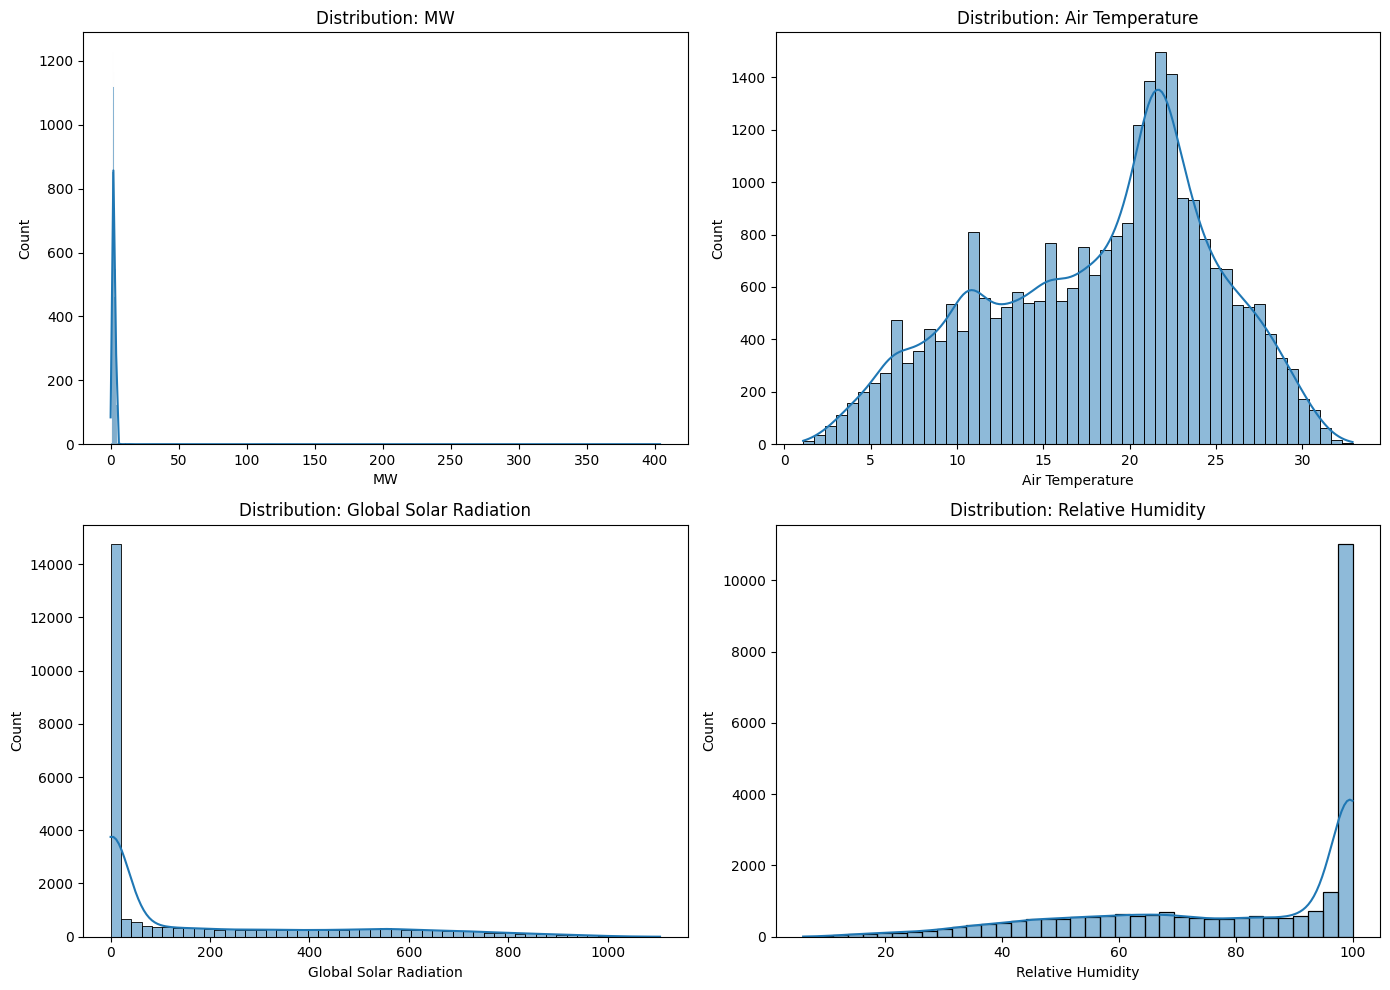

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(14,10))
cols_plot = ['MW','Air Temperature','Global Solar Radiation','Relative Humidity']
for ax, col in zip(axes.ravel(), cols_plot):
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(f'Distribution: {col}')
plt.tight_layout(); plt.show()

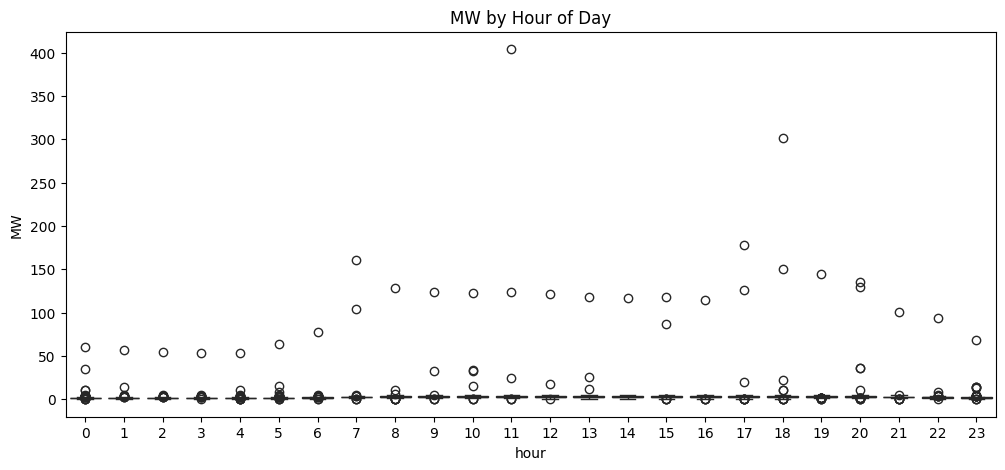

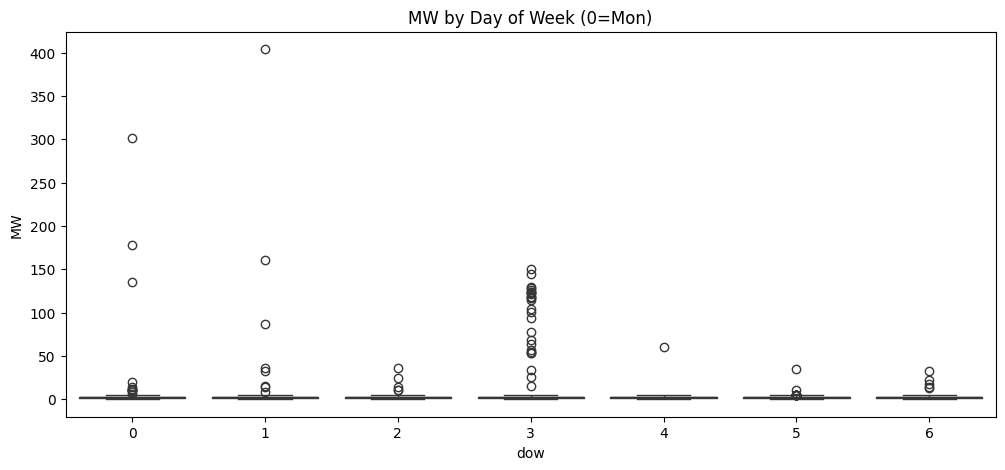

In [ ]:
# Hour-of-day pattern
df['hour'] = df.index.hour
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(x='hour', y='MW', data=df, palette='Blues')
ax.set_title('MW by Hour of Day')
plt.show()

# Day-of-week pattern
df['dow'] = df.index.dayofweek
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(x='dow', y='MW', data=df, palette='Purples')
ax.set_title('MW by Day of Week (0=Mon)')
plt.show()

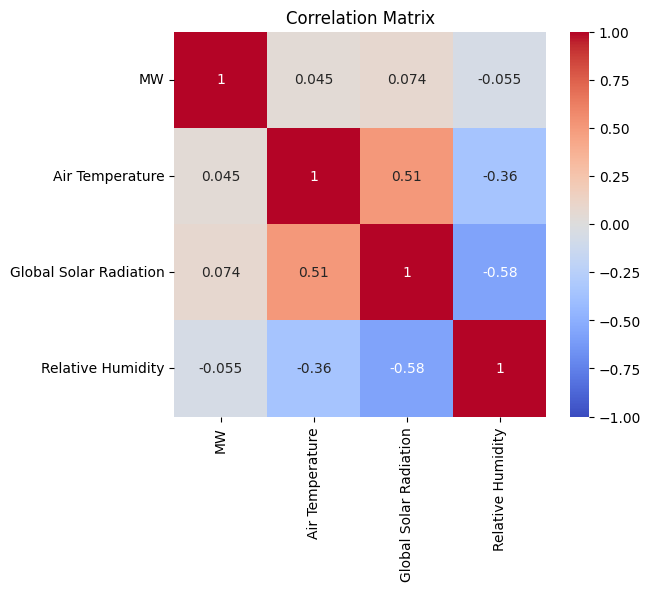

In [ ]:
# Correlation matrix
corr = df[['MW','Air Temperature','Global Solar Radiation','Relative Humidity']].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

## 4. Feature Engineering
We create supervised learning features for deep models:
- Lags (1..LAG_MAX)
- Rolling statistics (mean/std on windows)
- Cyclical encodings: sin/cos(hour, day-of-week)
- Fourier terms for daily (period=24) & weekly (period=168)
- Interaction terms (Radiation*Temperature)
- Log1p transform for target (stabilizes skew)

We will later slice sequences for models with a context window.

In [ ]:
LAG_MAX = 168  # up to one week of hourly lags
ROLL_WINDOWS = [3,6,12,24]

fe = pd.DataFrame(index=df.index)
fe['MW'] = df['MW']
fe['temp'] = df['Air Temperature']
fe['rad'] = df['Global Solar Radiation']
fe['hum'] = df['Relative Humidity']

# Interactions
fe['rad_temp'] = fe['rad'] * fe['temp']

# Cyclical encodings
fe['hour'] = df.index.hour
fe['dow'] = df.index.dayofweek
fe['sin_hour'] = np.sin(2*np.pi*fe['hour']/24)
fe['cos_hour'] = np.cos(2*np.pi*fe['hour']/24)
fe['sin_dow'] = np.sin(2*np.pi*fe['dow']/7)
fe['cos_dow'] = np.cos(2*np.pi*fe['dow']/7)

# Fourier terms
def fourier(series_length, period, K):
    t = np.arange(series_length)
    mats = {}
    for k in range(1, K+1):
        mats[f'sin_{period}_{k}'] = np.sin(2*np.pi*k*t/period)
        mats[f'cos_{period}_{k}'] = np.cos(2*np.pi*k*t/period)
    return pd.DataFrame(mats, index=fe.index)

daily_fourier = fourier(len(fe), 24, 3)
weekly_fourier = fourier(len(fe), 168, 2)
fe = pd.concat([fe, daily_fourier, weekly_fourier], axis=1)

# Lag features
for lag in range(1, LAG_MAX+1):
    fe[f'MW_lag_{lag}'] = fe['MW'].shift(lag)

# Rolling stats
for w in ROLL_WINDOWS:
    fe[f'MW_roll_mean_{w}'] = fe['MW'].rolling(w).mean()
    fe[f'MW_roll_std_{w}'] = fe['MW'].rolling(w).std()

# Target transform
fe['MW_log1p'] = np.log1p(fe['MW'])

# Drop initial rows with NaNs from lags/rolls
min_rows = LAG_MAX + max(ROLL_WINDOWS)
fe = fe.iloc[min_rows:]
print('Feature shape:', fe.shape)
fe.head()

Feature shape: (26088, 198)


,MW,temp,rad,hum,rad_temp,hour,dow,sin_hour,cos_hour,sin_dow,...,MW_lag_168,MW_roll_mean_3,MW_roll_std_3,MW_roll_mean_6,MW_roll_std_6,MW_roll_mean_12,MW_roll_std_12,MW_roll_mean_24,MW_roll_std_24,MW_log1p
Time,,,,,,,,,,,,,,,,,,,,,
2022-10-27 01:00:00,1.1,13.70,0.0,92.4,0.0,1,3,0.258819,0.965926,0.433884,...,57.0,1.233333,0.152753,1.616667,0.470815,1.716667,0.419596,1.612500,0.350543,0.741937
2022-10-27 02:00:00,1.0,13.20,0.0,96.4,0.0,2,3,0.500000,0.866025,0.433884,...,54.0,1.100000,0.100000,1.400000,0.384708,1.666667,0.467748,1.604167,0.362934,0.693147
2022-10-27 03:00:00,1.0,14.20,0.0,93.1,0.0,3,3,0.707107,0.707107,0.433884,...,53.0,1.033333,0.057735,1.233333,0.273252,1.625000,0.504750,1.595833,0.374722,0.693147
2022-10-27 04:00:00,1.0,13.55,0.0,96.5,0.0,4,3,0.866025,0.500000,0.433884,...,53.0,1.000000,0.000000,1.116667,0.160208,1.575000,0.536190,1.587500,0.385963,0.693147
2022-10-27 05:00:00,1.4,12.90,0.0,99.9,0.0,5,3,0.965926,0.258819,0.433884,...,64.0,1.133333,0.230940,1.116667,0.160208,1.558333,0.538446,1.591667,0.383255,0.875469


## 5. Train / Validation / Test Split
- We use chronological splits.
- Example: 70% train, 15% validation, 15% test.
- Adjust as needed.
- All splits maintain sequence order.

In [ ]:
train_ratio, val_ratio = 0.7, 0.15
n = len(fe)
train_end = int(n*train_ratio)
val_end = int(n*(train_ratio+val_ratio))

train_df = fe.iloc[:train_end]
val_df = fe.iloc[train_end:val_end]
test_df = fe.iloc[val_end:]
print('Train/Val/Test sizes:', len(train_df), len(val_df), len(test_df))

Train/Val/Test sizes: 18261 3913 3914


## 6. Scaling & Tensor Dataset Preparation
We scale features (excluding the original `MW` target which we keep separate). Sequences are constructed with a context window and a multi-step horizon.

In [ ]:
HORIZON = 24  # forecast next 24 hours
CONTEXT_WINDOW = 168  # use last week of data as input sequence

# Identify feature columns (exclude raw MW and MW_log1p from features destined for prediction)
target_col = 'MW_log1p'
exclude_cols = ['MW','MW_log1p']
feature_cols = [c for c in train_df.columns if c not in exclude_cols]
print('Number of features:', len(feature_cols))

scaler = StandardScaler()
train_scaled = train_df.copy()
train_scaled[feature_cols] = scaler.fit_transform(train_scaled[feature_cols])
val_scaled = val_df.copy()
val_scaled[feature_cols] = scaler.transform(val_scaled[feature_cols])
test_scaled = test_df.copy()
test_scaled[feature_cols] = scaler.transform(test_scaled[feature_cols])

class SeqDataset(Dataset):
    def __init__(self, df, feature_cols, target_col, context, horizon):
        self.df = df
        self.X = df[feature_cols].values.astype(np.float32)
        self.y = df[target_col].values.astype(np.float32)
        self.context = context
        self.horizon = horizon
    def __len__(self):
        return len(self.df) - self.context - self.horizon + 1
    def __getitem__(self, idx):
        start = idx
        end = idx + self.context
        y_start = end
        y_end = end + self.horizon
        X_seq = self.X[start:end]
        y_seq = self.y[y_start:y_end]  # horizon targets
        return torch.from_numpy(X_seq), torch.from_numpy(y_seq)

train_ds = SeqDataset(train_scaled, feature_cols, target_col, CONTEXT_WINDOW, HORIZON)
val_ds = SeqDataset(val_scaled, feature_cols, target_col, CONTEXT_WINDOW, HORIZON)
test_ds = SeqDataset(test_scaled, feature_cols, target_col, CONTEXT_WINDOW, HORIZON)
print('Train/Val/Test dataset lengths:', len(train_ds), len(val_ds), len(test_ds))

BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, pin_memory=True)

Number of features: 196
Train/Val/Test dataset lengths: 18070 3722 3723


## 7. Metrics & Utility Functions
We define regression metrics and a pseudo-accuracy metric for visualization.

In [ ]:
def safe_mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    denom = np.where(np.abs(y_true) < 1e-6, 1e-6, np.abs(y_true))
    return np.mean(np.abs((y_true - y_pred)/denom))*100
def smape(y_true, y_pred):
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    denom = (np.abs(y_true)+np.abs(y_pred))
    denom = np.where(denom==0,1e-6,denom)
    return 100*np.mean(2*np.abs(y_pred - y_true)/denom)
def mase(y_true, y_pred, y_train, m=24):
    y_true = np.array(y_true); y_pred = np.array(y_pred); y_train = np.array(y_train)
    if len(y_train) <= m: return np.nan
    naive = np.mean(np.abs(y_train[m:] - y_train[:-m]))
    if naive == 0: return np.nan
    return np.mean(np.abs(y_true - y_pred))/naive
def pseudo_accuracy(y_true, y_pred):
    # Clip values after expm1 to prevent infinity/overflow in metrics
    y_true = np.clip(y_true, a_min=0, a_max=1e9)
    y_pred = np.clip(y_pred, a_min=0, a_max=1e9)
    mae = mean_absolute_error(y_true, y_pred)
    denom = np.mean(np.abs(y_true)) + 1e-8
    return max(0.0, 1 - mae/denom)

def evaluate_arrays(y_true_lin, y_pred_lin, y_train_lin):
    metrics = {}
    # Clip values after expm1 to prevent infinity/overflow in metrics
    y_true_lin = np.clip(y_true_lin, a_min=0, a_max=1e9)
    y_pred_lin = np.clip(y_pred_lin, a_min=0, a_max=1e9)
    y_train_lin = np.clip(y_train_lin, a_min=0, a_max=1e9)

    metrics['MAE'] = mean_absolute_error(y_true_lin, y_pred_lin)
    # Removed squared=False and added np.sqrt for compatibility with older sklearn versions
    metrics['RMSE'] = np.sqrt(mean_squared_error(y_true_lin, y_pred_lin))
    metrics['R2'] = r2_score(y_true_lin, y_pred_lin)
    metrics['MAPE'] = safe_mape(y_true_lin, y_pred_lin)
    metrics['sMAPE'] = smape(y_true_lin, y_pred_lin)
    metrics['MASE'] = mase(y_true_lin, y_pred_lin, y_train_lin)
    metrics['PseudoAccuracy'] = pseudo_accuracy(y_true_lin, y_pred_lin)
    return metrics

## 8. Model Definitions
We implement modular PyTorch models:
- MLP
- LSTM
- GRU
- TCN
- N-BEATS (simplified)
- Transformer Encoder

All output shape: `[batch, HORIZON]` (direct multi-step).

In [ ]:
class MLPRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout, horizon):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev = h
        layers.append(nn.Linear(prev, horizon))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        b, s, f = x.shape
        z = x.reshape(b, s*f)
        return self.net(z)

class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout, horizon):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, horizon)
    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.fc(last)

class GRURegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout, horizon):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, horizon)
    def forward(self, x):
        out, _ = self.gru(x)
        last = out[:, -1, :]
        return self.fc(last)

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__(); self.chomp_size = chomp_size
    def forward(self, x):
        return x[:, :, :-self.chomp_size]

class TemporalBlock(nn.Module):
    def __init__(self, in_ch, out_ch, k, dilation, dropout):
        super().__init__()
        padding = (k - 1) * dilation
        self.conv1 = nn.Conv1d(in_ch, out_ch, k, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(out_ch, out_ch, k, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(dropout)
        self.downsample = nn.Conv1d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
        self.final_relu = nn.ReLU()
    def forward(self, x):
        y = self.conv1(x); y = self.chomp1(y); y = self.relu1(y); y = self.drop1(y)
        y = self.conv2(y); y = self.chomp2(y); y = self.relu2(y); y = self.drop2(y)
        return self.final_relu(y + self.downsample(x))

class TCNRegressor(nn.Module):
    def __init__(self, input_dim, channels, kernel_size, dropout, horizon):
        super().__init__()
        layers = []
        prev = input_dim
        for i, ch in enumerate(channels):
            dilation = 2 ** i
            layers.append(TemporalBlock(prev, ch, kernel_size, dilation, dropout))
            prev = ch
        self.net = nn.Sequential(*layers)
        self.fc = nn.Linear(channels[-1], horizon)
    def forward(self, x):
        x = x.transpose(1,2)
        y = self.net(x).transpose(1,2)
        last = y[:, -1, :]
        return self.fc(last)

class NBeatsBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, horizon, thetas_dim):
        super().__init__()
        self.fc_stack = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, thetas_dim)
        )
        self.backcast_lin = nn.Linear(thetas_dim, input_dim)
        self.forecast_lin = nn.Linear(thetas_dim, horizon)
    def forward(self, x):
        b, s, f = x.shape
        inp = x.reshape(b, s*f)
        theta = self.fc_stack(inp)
        backcast = self.backcast_lin(theta).reshape(b, s, f)
        forecast = self.forecast_lin(theta)
        return backcast, forecast

class NBeatsRegressor(nn.Module):
    def __init__(self, input_dim, seq_len, feat_dim, hidden_dim, horizon, n_blocks=2, thetas_dim=64):
        super().__init__()
        blocks = []
        for _ in range(n_blocks):
            blocks.append(NBeatsBlock(seq_len*feat_dim, hidden_dim, horizon, thetas_dim))
        self.blocks = nn.ModuleList(blocks)
    def forward(self, x):
        residual = x
        forecast_final = 0
        for block in self.blocks:
            backcast, forecast = block(residual)
            residual = residual - backcast
            forecast_final = forecast_final + forecast
        return forecast_final

class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward, dropout, horizon, max_len=1000):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_emb = nn.Parameter(torch.zeros(1, max_len, d_model))
        enc_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers)
        self.fc = nn.Linear(d_model, horizon)
    def forward(self, x):
        seq_len = x.size(1)
        z = self.input_proj(x) + self.pos_emb[:, :seq_len, :]
        h = self.encoder(z)
        last = h[:, -1, :]
        return self.fc(last)

## 9. Generic Training & Validation Loop
We implement a reusable function with:
- AMP mixed precision
- Early stopping
- Metric tracking
Each trial returns validation MAE (primary objective).

In [ ]:
def train_model(model, optimizer, train_loader, val_loader, epochs, horizon, scaler_amp=True, patience=10):
    criterion = nn.MSELoss()
    scaler = GradScaler(enabled=scaler_amp and DEVICE=='cuda')
    best_val = float('inf')
    best_state = None
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    es_counter = 0

    for epoch in range(1, epochs+1):
        model.train()
        total_loss = 0.0
        preds_all, trues_all = [], []
        for X, y in train_loader:
            X = X.to(DEVICE)
            y = y.to(DEVICE)
            optimizer.zero_grad()
            with autocast(enabled=scaler_amp and DEVICE=='cuda'):
                out = model(X)
                # Clamp model output to a reasonable range for log-transformed target (e.g., -1 to 10)
                out = torch.clamp(out, min=-1.0, max=10.0)
                loss = criterion(out, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item() * X.size(0)
            preds_all.append(out.detach().cpu().numpy())
            trues_all.append(y.cpu().numpy())
        train_loss = total_loss / len(train_loader.dataset)
        preds_train = np.concatenate(preds_all, axis=0)
        trues_train = np.concatenate(trues_all, axis=0)
        train_acc = pseudo_accuracy(np.expm1(trues_train.flatten()), np.expm1(preds_train.flatten()))

        model.eval()
        val_loss_tot = 0.0
        v_preds, v_trues = [], []
        with torch.no_grad():
            for Xv, yv in val_loader:
                Xv = Xv.to(DEVICE); yv = yv.to(DEVICE)
                ov = model(Xv)
                # Clamp model output for validation
                ov = torch.clamp(ov, min=-1.0, max=10.0)
                vloss = criterion(ov, yv)
                val_loss_tot += vloss.item() * Xv.size(0)
                v_preds.append(ov.cpu().numpy())
                v_trues.append(yv.cpu().numpy())
        val_loss = val_loss_tot / len(val_loader.dataset)
        v_preds = np.concatenate(v_preds, axis=0)
        v_trues = np.concatenate(v_trues, axis=0)
        val_acc = pseudo_accuracy(np.expm1(v_trues.flatten()), np.expm1(v_preds.flatten()))

        train_losses.append(train_loss); val_losses.append(val_loss)
        train_accs.append(train_acc); val_accs.append(val_acc)

        if val_loss < best_val:
            best_val = val_loss
            best_state = model.state_dict()
            es_counter = 0
        else:
            es_counter += 1

        if epoch % 5 == 0 or epoch == 1:
            print(f'Epoch {epoch} | TrainLoss {train_loss:.4f} | ValLoss {val_loss:.4f} | TrainAcc {train_acc:.3f} | ValAcc {val_acc:.3f}')

        if es_counter >= patience:
            print('Early stopping triggered.')
            break

    model.load_state_dict(best_state)
    history = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_acc': train_accs,
        'val_acc': val_accs,
        'best_val_loss': best_val
    }
    return model, history

## 10. Hyperparameter Tuning with Optuna
Separate studies for each architecture. Adjust trial counts to manage runtime.

In [ ]:
MAX_TRIALS_MLP = 10
MAX_TRIALS_LSTM = 10
MAX_TRIALS_GRU = 8
MAX_TRIALS_TCN = 8
MAX_TRIALS_NBEATS = 6
MAX_TRIALS_TRANSFORMER = 8

EPOCHS_PER_TRIAL = 30

results_summary = {}
model_artifacts = {}
os.makedirs('models', exist_ok=True)

def objective_mlp(trial):
    hidden_layers = trial.suggest_int('hidden_layers', 2, 4)
    hidden_dim = trial.suggest_categorical('hidden_dim', [128,256,512])
    dropout = trial.suggest_float('dropout', 0.1, 0.4)
    lr = trial.suggest_float('lr', 1e-4, 5e-3, log=True)
    hidden_dims = [hidden_dim]*hidden_layers
    model = MLPRegressor(len(feature_cols)*CONTEXT_WINDOW, hidden_dims, dropout, HORIZON).to(DEVICE)
    optimizer = AdamW(model.parameters(), lr=lr)
    tuned_model, history = train_model(model, optimizer, train_loader, val_loader, EPOCHS_PER_TRIAL, HORIZON)
    val_loss = history['best_val_loss']
    trial.set_user_attr('history', history)
    trial.set_user_attr('state_dict', tuned_model.state_dict())
    return val_loss

study_mlp = optuna.create_study(direction='minimize', study_name='MLP')
study_mlp.optimize(objective_mlp, n_trials=MAX_TRIALS_MLP)
print('Best MLP params:', study_mlp.best_trial.params)
best_trial = study_mlp.best_trial
mlp_history = best_trial.user_attrs['history']
mlp_model = MLPRegressor(len(feature_cols)*CONTEXT_WINDOW,
                         [best_trial.params['hidden_dim']]*best_trial.params['hidden_layers'],
                         best_trial.params['dropout'], HORIZON).to(DEVICE)
mlp_model.load_state_dict(best_trial.user_attrs['state_dict'])
torch.save(mlp_model.state_dict(), 'models/best_mlp.pt')
results_summary['MLP_val_loss'] = mlp_history['best_val_loss']
model_artifacts['MLP'] = {'model': mlp_model, 'history': mlp_history}

[I 2025-12-03 07:12:47,295] A new study created in memory with name: MLP


Epoch 1 | TrainLoss 0.1609 | ValLoss 0.2200 | TrainAcc 0.536 | ValAcc 0.319
Epoch 5 | TrainLoss 0.0434 | ValLoss 0.0988 | TrainAcc 0.778 | ValAcc 0.627
Epoch 10 | TrainLoss 0.0350 | ValLoss 0.0777 | TrainAcc 0.811 | ValAcc 0.664
Epoch 15 | TrainLoss 0.0333 | ValLoss 0.0664 | TrainAcc 0.818 | ValAcc 0.692
Epoch 20 | TrainLoss 0.0317 | ValLoss 0.0674 | TrainAcc 0.824 | ValAcc 0.692
Epoch 25 | TrainLoss 0.0314 | ValLoss 0.0643 | TrainAcc 0.825 | ValAcc 0.702


[I 2025-12-03 07:15:32,475] Trial 0 finished with value: 0.062407400517102404 and parameters: {'hidden_layers': 4, 'hidden_dim': 256, 'dropout': 0.25964358513264296, 'lr': 0.0012152776951576624}. Best is trial 0 with value: 0.062407400517102404.


Epoch 30 | TrainLoss 0.0316 | ValLoss 0.0624 | TrainAcc 0.823 | ValAcc 0.708
Epoch 1 | TrainLoss 0.1440 | ValLoss 0.3431 | TrainAcc 0.576 | ValAcc 0.000
Epoch 5 | TrainLoss 0.0418 | ValLoss 0.1439 | TrainAcc 0.787 | ValAcc 0.516
Epoch 10 | TrainLoss 0.0331 | ValLoss 0.1227 | TrainAcc 0.818 | ValAcc 0.569
Epoch 15 | TrainLoss 0.0307 | ValLoss 0.1145 | TrainAcc 0.828 | ValAcc 0.584
Epoch 20 | TrainLoss 0.0284 | ValLoss 0.0933 | TrainAcc 0.837 | ValAcc 0.622
Epoch 25 | TrainLoss 0.0273 | ValLoss 0.0795 | TrainAcc 0.841 | ValAcc 0.653


[I 2025-12-03 07:17:50,728] Trial 1 finished with value: 0.07041285719676468 and parameters: {'hidden_layers': 3, 'hidden_dim': 256, 'dropout': 0.1512874610292274, 'lr': 0.0005508873654146029}. Best is trial 0 with value: 0.062407400517102404.


Epoch 30 | TrainLoss 0.0257 | ValLoss 0.0741 | TrainAcc 0.848 | ValAcc 0.668
Epoch 1 | TrainLoss 0.9883 | ValLoss 0.1822 | TrainAcc 0.000 | ValAcc 0.475
Epoch 5 | TrainLoss 0.0485 | ValLoss 0.0680 | TrainAcc 0.763 | ValAcc 0.692
Epoch 10 | TrainLoss 0.0493 | ValLoss 0.0674 | TrainAcc 0.760 | ValAcc 0.694
Epoch 15 | TrainLoss 0.0600 | ValLoss 0.0823 | TrainAcc 0.728 | ValAcc 0.653


[I 2025-12-03 07:19:13,470] Trial 2 finished with value: 0.06280535065970838 and parameters: {'hidden_layers': 4, 'hidden_dim': 256, 'dropout': 0.20264114939903138, 'lr': 0.004841192549604327}. Best is trial 0 with value: 0.062407400517102404.


Early stopping triggered.
Epoch 1 | TrainLoss 0.1238 | ValLoss 0.1458 | TrainAcc 0.612 | ValAcc 0.000
Epoch 5 | TrainLoss 0.0413 | ValLoss 0.0762 | TrainAcc 0.789 | ValAcc 0.000
Epoch 10 | TrainLoss 0.0352 | ValLoss 0.0529 | TrainAcc 0.810 | ValAcc 0.738
Epoch 15 | TrainLoss 0.0376 | ValLoss 0.0564 | TrainAcc 0.801 | ValAcc 0.734


[I 2025-12-03 07:20:34,584] Trial 3 finished with value: 0.05290554366577447 and parameters: {'hidden_layers': 4, 'hidden_dim': 128, 'dropout': 0.13719766764589875, 'lr': 0.0036488709559496456}. Best is trial 3 with value: 0.05290554366577447.


Epoch 20 | TrainLoss 0.0402 | ValLoss 0.0606 | TrainAcc 0.791 | ValAcc 0.717
Early stopping triggered.
Epoch 1 | TrainLoss 0.1859 | ValLoss 0.3505 | TrainAcc 0.482 | ValAcc 0.329
Epoch 5 | TrainLoss 0.0580 | ValLoss 0.1880 | TrainAcc 0.732 | ValAcc 0.498
Epoch 10 | TrainLoss 0.0381 | ValLoss 0.1155 | TrainAcc 0.797 | ValAcc 0.596
Epoch 15 | TrainLoss 0.0346 | ValLoss 0.0732 | TrainAcc 0.811 | ValAcc 0.676
Epoch 20 | TrainLoss 0.0338 | ValLoss 0.0765 | TrainAcc 0.816 | ValAcc 0.669
Epoch 25 | TrainLoss 0.0346 | ValLoss 0.0736 | TrainAcc 0.812 | ValAcc 0.678


[I 2025-12-03 07:23:29,008] Trial 4 finished with value: 0.06847430952593948 and parameters: {'hidden_layers': 4, 'hidden_dim': 512, 'dropout': 0.3451941728430382, 'lr': 0.0009174769181948708}. Best is trial 3 with value: 0.05290554366577447.


Epoch 30 | TrainLoss 0.0340 | ValLoss 0.0718 | TrainAcc 0.813 | ValAcc 0.682
Epoch 1 | TrainLoss 0.2332 | ValLoss 0.4129 | TrainAcc 0.420 | ValAcc 0.000
Epoch 5 | TrainLoss 0.0704 | ValLoss 0.1503 | TrainAcc 0.708 | ValAcc 0.484
Epoch 10 | TrainLoss 0.0464 | ValLoss 0.1782 | TrainAcc 0.773 | ValAcc 0.457


[I 2025-12-03 07:24:34,423] Trial 5 finished with value: 0.15025871772317076 and parameters: {'hidden_layers': 2, 'hidden_dim': 256, 'dropout': 0.2514501825388432, 'lr': 0.00013299283265365286}. Best is trial 3 with value: 0.05290554366577447.


Epoch 15 | TrainLoss 0.0388 | ValLoss 0.1665 | TrainAcc 0.799 | ValAcc 0.500
Early stopping triggered.
Epoch 1 | TrainLoss 0.1970 | ValLoss 0.2414 | TrainAcc 0.491 | ValAcc 0.387
Epoch 5 | TrainLoss 0.0714 | ValLoss 0.2625 | TrainAcc 0.699 | ValAcc 0.427
Epoch 10 | TrainLoss 0.0523 | ValLoss 0.2348 | TrainAcc 0.748 | ValAcc 0.459
Epoch 15 | TrainLoss 0.0431 | ValLoss 0.3256 | TrainAcc 0.777 | ValAcc 0.389


[I 2025-12-03 07:26:08,186] Trial 6 finished with value: 0.2136883807560246 and parameters: {'hidden_layers': 3, 'hidden_dim': 512, 'dropout': 0.3850360811273059, 'lr': 0.00014419302560347594}. Best is trial 3 with value: 0.05290554366577447.


Early stopping triggered.
Epoch 1 | TrainLoss 0.2272 | ValLoss 0.3028 | TrainAcc 0.459 | ValAcc 0.312
Epoch 5 | TrainLoss 0.0506 | ValLoss 0.0877 | TrainAcc 0.755 | ValAcc 0.644
Epoch 10 | TrainLoss 0.0397 | ValLoss 0.0940 | TrainAcc 0.791 | ValAcc 0.630


[I 2025-12-03 07:27:12,202] Trial 7 finished with value: 0.08769809584994588 and parameters: {'hidden_layers': 4, 'hidden_dim': 128, 'dropout': 0.2827021205104605, 'lr': 0.0005833743397482036}. Best is trial 3 with value: 0.05290554366577447.


Epoch 15 | TrainLoss 0.0353 | ValLoss 0.0966 | TrainAcc 0.808 | ValAcc 0.626
Early stopping triggered.
Epoch 1 | TrainLoss 0.6149 | ValLoss 0.3461 | TrainAcc 0.000 | ValAcc 0.000
Epoch 5 | TrainLoss 0.0607 | ValLoss 0.0722 | TrainAcc 0.730 | ValAcc 0.683
Epoch 10 | TrainLoss 0.0536 | ValLoss 0.0749 | TrainAcc 0.748 | ValAcc 0.676
Epoch 15 | TrainLoss 0.0565 | ValLoss 0.0738 | TrainAcc 0.730 | ValAcc 0.684
Epoch 20 | TrainLoss 0.0583 | ValLoss 0.0792 | TrainAcc 0.733 | ValAcc 0.669
Epoch 25 | TrainLoss 0.0643 | ValLoss 0.0840 | TrainAcc 0.716 | ValAcc 0.653


[I 2025-12-03 07:29:08,869] Trial 8 finished with value: 0.07102205096666432 and parameters: {'hidden_layers': 2, 'hidden_dim': 256, 'dropout': 0.31763843873979647, 'lr': 0.0022044251842306215}. Best is trial 3 with value: 0.05290554366577447.


Early stopping triggered.
Epoch 1 | TrainLoss 0.2892 | ValLoss 0.3488 | TrainAcc 0.253 | ValAcc 0.091
Epoch 5 | TrainLoss 0.0590 | ValLoss 0.2091 | TrainAcc 0.732 | ValAcc 0.477
Epoch 10 | TrainLoss 0.0415 | ValLoss 0.1376 | TrainAcc 0.784 | ValAcc 0.564
Epoch 15 | TrainLoss 0.0357 | ValLoss 0.0913 | TrainAcc 0.805 | ValAcc 0.636
Epoch 20 | TrainLoss 0.0333 | ValLoss 0.0769 | TrainAcc 0.816 | ValAcc 0.666
Epoch 25 | TrainLoss 0.0323 | ValLoss 0.0703 | TrainAcc 0.820 | ValAcc 0.680


[I 2025-12-03 07:31:02,107] Trial 9 finished with value: 0.06760307731910588 and parameters: {'hidden_layers': 3, 'hidden_dim': 128, 'dropout': 0.30589867013110655, 'lr': 0.0007679390439573061}. Best is trial 3 with value: 0.05290554366577447.


Epoch 30 | TrainLoss 0.0318 | ValLoss 0.0769 | TrainAcc 0.823 | ValAcc 0.669
Best MLP params: {'hidden_layers': 4, 'hidden_dim': 128, 'dropout': 0.13719766764589875, 'lr': 0.0036488709559496456}


In [ ]:
def objective_lstm(trial):
    hidden_dim = trial.suggest_categorical('hidden_dim', [64,128,256])
    num_layers = trial.suggest_int('num_layers', 1, 3)
    dropout = trial.suggest_float('dropout', 0.0, 0.4)
    lr = trial.suggest_float('lr', 1e-4, 5e-3, log=True)
    model = LSTMRegressor(len(feature_cols), hidden_dim, num_layers, dropout, HORIZON).to(DEVICE)
    optimizer = Adam(model.parameters(), lr=lr)
    tuned_model, history = train_model(model, optimizer, train_loader, val_loader, EPOCHS_PER_TRIAL, HORIZON)
    val_loss = history['best_val_loss']
    trial.set_user_attr('history', history)
    trial.set_user_attr('state_dict', tuned_model.state_dict())
    return val_loss

study_lstm = optuna.create_study(direction='minimize', study_name='LSTM')
study_lstm.optimize(objective_lstm, n_trials=MAX_TRIALS_LSTM)
print('Best LSTM params:', study_lstm.best_trial.params)
best_trial = study_lstm.best_trial
lstm_history = best_trial.user_attrs['history']
lstm_model = LSTMRegressor(len(feature_cols),
                           best_trial.params['hidden_dim'],
                           best_trial.params['num_layers'],
                           best_trial.params['dropout'], HORIZON).to(DEVICE)
lstm_model.load_state_dict(best_trial.user_attrs['state_dict'])
torch.save(lstm_model.state_dict(), 'models/best_lstm.pt')
results_summary['LSTM_val_loss'] = lstm_history['best_val_loss']
model_artifacts['LSTM'] = {'model': lstm_model, 'history': lstm_history}

[I 2025-12-03 07:31:02,176] A new study created in memory with name: LSTM


Epoch 1 | TrainLoss 0.2829 | ValLoss 0.0617 | TrainAcc 0.591 | ValAcc 0.715
Epoch 5 | TrainLoss 0.0252 | ValLoss 0.0450 | TrainAcc 0.858 | ValAcc 0.774
Epoch 10 | TrainLoss 0.0205 | ValLoss 0.0437 | TrainAcc 0.879 | ValAcc 0.783
Epoch 15 | TrainLoss 0.0175 | ValLoss 0.0467 | TrainAcc 0.893 | ValAcc 0.777


[I 2025-12-03 07:32:17,041] Trial 0 finished with value: 0.041806006935224425 and parameters: {'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.06219927216009147, 'lr': 0.00011902693630682596}. Best is trial 0 with value: 0.041806006935224425.


Early stopping triggered.
Epoch 1 | TrainLoss 0.2147 | ValLoss 0.0576 | TrainAcc 0.619 | ValAcc 0.722
Epoch 5 | TrainLoss 0.0225 | ValLoss 0.0419 | TrainAcc 0.868 | ValAcc 0.783
Epoch 10 | TrainLoss 0.0170 | ValLoss 0.0460 | TrainAcc 0.896 | ValAcc 0.774


[I 2025-12-03 07:33:30,039] Trial 1 finished with value: 0.04192126155988559 and parameters: {'hidden_dim': 128, 'num_layers': 3, 'dropout': 0.008571511837933211, 'lr': 0.00016164745926527783}. Best is trial 0 with value: 0.041806006935224425.


Epoch 15 | TrainLoss 0.0148 | ValLoss 0.0456 | TrainAcc 0.906 | ValAcc 0.785
Early stopping triggered.
Epoch 1 | TrainLoss 0.1108 | ValLoss 0.0443 | TrainAcc 0.725 | ValAcc 0.769
Epoch 5 | TrainLoss 0.0190 | ValLoss 0.0414 | TrainAcc 0.884 | ValAcc 0.789
Epoch 10 | TrainLoss 0.0147 | ValLoss 0.0440 | TrainAcc 0.905 | ValAcc 0.784


[I 2025-12-03 07:34:32,036] Trial 2 finished with value: 0.04056727259246205 and parameters: {'hidden_dim': 128, 'num_layers': 3, 'dropout': 0.15478439915461226, 'lr': 0.0005740909954759204}. Best is trial 2 with value: 0.04056727259246205.


Early stopping triggered.
Epoch 1 | TrainLoss 0.0586 | ValLoss 0.0414 | TrainAcc 0.786 | ValAcc 0.775
Epoch 5 | TrainLoss 0.0171 | ValLoss 0.0393 | TrainAcc 0.894 | ValAcc 0.790
Epoch 10 | TrainLoss 0.0131 | ValLoss 0.0435 | TrainAcc 0.912 | ValAcc 0.782


[I 2025-12-03 07:35:34,643] Trial 3 finished with value: 0.03819836083597422 and parameters: {'hidden_dim': 128, 'num_layers': 3, 'dropout': 0.006264960500531514, 'lr': 0.0021413621622139774}. Best is trial 3 with value: 0.03819836083597422.


Early stopping triggered.
Epoch 1 | TrainLoss 0.1260 | ValLoss 0.0539 | TrainAcc 0.680 | ValAcc 0.731
Epoch 5 | TrainLoss 0.0205 | ValLoss 0.0408 | TrainAcc 0.875 | ValAcc 0.785
Epoch 10 | TrainLoss 0.0161 | ValLoss 0.0429 | TrainAcc 0.898 | ValAcc 0.785
Epoch 15 | TrainLoss 0.0143 | ValLoss 0.0457 | TrainAcc 0.906 | ValAcc 0.776


[I 2025-12-03 07:36:34,234] Trial 4 finished with value: 0.04029812313884513 and parameters: {'hidden_dim': 64, 'num_layers': 3, 'dropout': 0.15951746184513227, 'lr': 0.000879611899243213}. Best is trial 3 with value: 0.03819836083597422.


Early stopping triggered.
Epoch 1 | TrainLoss 0.0661 | ValLoss 0.0422 | TrainAcc 0.757 | ValAcc 0.772
Epoch 5 | TrainLoss 0.0188 | ValLoss 0.0394 | TrainAcc 0.884 | ValAcc 0.795
Epoch 10 | TrainLoss 0.0154 | ValLoss 0.0413 | TrainAcc 0.899 | ValAcc 0.789


[I 2025-12-03 07:37:29,883] Trial 5 finished with value: 0.03942197964420119 and parameters: {'hidden_dim': 64, 'num_layers': 3, 'dropout': 0.39096139243903855, 'lr': 0.004203182679440731}. Best is trial 3 with value: 0.03819836083597422.


Epoch 15 | TrainLoss 0.0130 | ValLoss 0.0436 | TrainAcc 0.909 | ValAcc 0.781
Early stopping triggered.
Epoch 1 | TrainLoss 0.2606 | ValLoss 0.0845 | TrainAcc 0.566 | ValAcc 0.640
Epoch 5 | TrainLoss 0.0246 | ValLoss 0.0446 | TrainAcc 0.856 | ValAcc 0.777
Epoch 10 | TrainLoss 0.0196 | ValLoss 0.0463 | TrainAcc 0.879 | ValAcc 0.775


[I 2025-12-03 07:38:23,983] Trial 6 finished with value: 0.04428120957130005 and parameters: {'hidden_dim': 64, 'num_layers': 3, 'dropout': 0.21640424785680468, 'lr': 0.00026161836544258394}. Best is trial 3 with value: 0.03819836083597422.


Early stopping triggered.
Epoch 1 | TrainLoss 0.0987 | ValLoss 0.0443 | TrainAcc 0.766 | ValAcc 0.771
Epoch 5 | TrainLoss 0.0195 | ValLoss 0.0399 | TrainAcc 0.884 | ValAcc 0.796
Epoch 10 | TrainLoss 0.0151 | ValLoss 0.0446 | TrainAcc 0.905 | ValAcc 0.784


[I 2025-12-03 07:39:53,149] Trial 7 finished with value: 0.03975961931061835 and parameters: {'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.11335367480758643, 'lr': 0.00034449706052639973}. Best is trial 3 with value: 0.03819836083597422.


Early stopping triggered.
Epoch 1 | TrainLoss 0.0668 | ValLoss 0.0446 | TrainAcc 0.790 | ValAcc 0.764
Epoch 5 | TrainLoss 0.0184 | ValLoss 0.0392 | TrainAcc 0.888 | ValAcc 0.797
Epoch 10 | TrainLoss 0.0151 | ValLoss 0.0420 | TrainAcc 0.903 | ValAcc 0.787


[I 2025-12-03 07:40:47,003] Trial 8 finished with value: 0.03916757557819378 and parameters: {'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.00887324988404088, 'lr': 0.0023438317198891433}. Best is trial 3 with value: 0.03819836083597422.


Epoch 15 | TrainLoss 0.0130 | ValLoss 0.0437 | TrainAcc 0.912 | ValAcc 0.781
Early stopping triggered.
Epoch 1 | TrainLoss 0.0608 | ValLoss 0.0437 | TrainAcc 0.776 | ValAcc 0.762
Epoch 5 | TrainLoss 0.0180 | ValLoss 0.0412 | TrainAcc 0.888 | ValAcc 0.785
Epoch 10 | TrainLoss 0.0148 | ValLoss 0.0406 | TrainAcc 0.901 | ValAcc 0.793


[I 2025-12-03 07:41:41,790] Trial 9 finished with value: 0.03815277237074789 and parameters: {'hidden_dim': 64, 'num_layers': 3, 'dropout': 0.04645331582544979, 'lr': 0.0045679063440418515}. Best is trial 9 with value: 0.03815277237074789.


Early stopping triggered.
Best LSTM params: {'hidden_dim': 64, 'num_layers': 3, 'dropout': 0.04645331582544979, 'lr': 0.0045679063440418515}


In [ ]:
def objective_gru(trial):
    hidden_dim = trial.suggest_categorical('hidden_dim', [64,128,256])
    num_layers = trial.suggest_int('num_layers', 1, 3)
    dropout = trial.suggest_float('dropout', 0.0, 0.4)
    lr = trial.suggest_float('lr', 1e-4, 5e-3, log=True)
    model = GRURegressor(len(feature_cols), hidden_dim, num_layers, dropout, HORIZON).to(DEVICE)
    optimizer = AdamW(model.parameters(), lr=lr)
    tuned_model, history = train_model(model, optimizer, train_loader, val_loader, EPOCHS_PER_TRIAL, HORIZON)
    val_loss = history['best_val_loss']
    trial.set_user_attr('history', history)
    trial.set_user_attr('state_dict', tuned_model.state_dict())
    return val_loss

study_gru = optuna.create_study(direction='minimize', study_name='GRU')
study_gru.optimize(objective_gru, n_trials=MAX_TRIALS_GRU)
print('Best GRU params:', study_gru.best_trial.params)
best_trial = study_gru.best_trial
gru_history = best_trial.user_attrs['history']
gru_model = GRURegressor(len(feature_cols),
                         best_trial.params['hidden_dim'],
                         best_trial.params['num_layers'],
                         best_trial.params['dropout'], HORIZON).to(DEVICE)
gru_model.load_state_dict(best_trial.user_attrs['state_dict'])
torch.save(gru_model.state_dict(), 'models/best_gru.pt')
results_summary['GRU_val_loss'] = gru_history['best_val_loss']
model_artifacts['GRU'] = {'model': gru_model, 'history': gru_history}

[I 2025-12-03 07:41:41,817] A new study created in memory with name: GRU


Epoch 1 | TrainLoss 0.1211 | ValLoss 0.0588 | TrainAcc 0.752 | ValAcc 0.753
Epoch 5 | TrainLoss 0.0226 | ValLoss 0.0505 | TrainAcc 0.871 | ValAcc 0.788
Epoch 10 | TrainLoss 0.0197 | ValLoss 0.0529 | TrainAcc 0.883 | ValAcc 0.770
Epoch 15 | TrainLoss 0.0175 | ValLoss 0.0508 | TrainAcc 0.892 | ValAcc 0.781
Epoch 20 | TrainLoss 0.0159 | ValLoss 0.0530 | TrainAcc 0.899 | ValAcc 0.772


[I 2025-12-03 07:42:55,179] Trial 0 finished with value: 0.04919103336455936 and parameters: {'hidden_dim': 128, 'num_layers': 1, 'dropout': 0.03629340064198896, 'lr': 0.0007241382546500791}. Best is trial 0 with value: 0.04919103336455936.


Early stopping triggered.
Epoch 1 | TrainLoss 0.4181 | ValLoss 0.1063 | TrainAcc 0.517 | ValAcc 0.712
Epoch 5 | TrainLoss 0.0283 | ValLoss 0.0570 | TrainAcc 0.848 | ValAcc 0.768
Epoch 10 | TrainLoss 0.0243 | ValLoss 0.0547 | TrainAcc 0.864 | ValAcc 0.772
Epoch 15 | TrainLoss 0.0223 | ValLoss 0.0528 | TrainAcc 0.873 | ValAcc 0.780
Epoch 20 | TrainLoss 0.0211 | ValLoss 0.0527 | TrainAcc 0.879 | ValAcc 0.783
Epoch 25 | TrainLoss 0.0202 | ValLoss 0.0538 | TrainAcc 0.883 | ValAcc 0.777


[I 2025-12-03 07:44:34,853] Trial 1 finished with value: 0.05195320221459846 and parameters: {'hidden_dim': 128, 'num_layers': 1, 'dropout': 0.39898604952077704, 'lr': 0.0001228638927986039}. Best is trial 0 with value: 0.04919103336455936.


Epoch 30 | TrainLoss 0.0194 | ValLoss 0.0528 | TrainAcc 0.886 | ValAcc 0.783
Epoch 1 | TrainLoss 0.0502 | ValLoss 0.0447 | TrainAcc 0.813 | ValAcc 0.775
Epoch 5 | TrainLoss 0.0186 | ValLoss 0.0422 | TrainAcc 0.885 | ValAcc 0.787
Epoch 10 | TrainLoss 0.0132 | ValLoss 0.0438 | TrainAcc 0.909 | ValAcc 0.783


[I 2025-12-03 07:46:16,766] Trial 2 finished with value: 0.041253493345116875 and parameters: {'hidden_dim': 256, 'num_layers': 3, 'dropout': 0.2546746905439644, 'lr': 0.0012066575054803473}. Best is trial 2 with value: 0.041253493345116875.


Early stopping triggered.
Epoch 1 | TrainLoss 0.0632 | ValLoss 0.0456 | TrainAcc 0.801 | ValAcc 0.769
Epoch 5 | TrainLoss 0.0206 | ValLoss 0.0408 | TrainAcc 0.878 | ValAcc 0.796
Epoch 10 | TrainLoss 0.0158 | ValLoss 0.0423 | TrainAcc 0.899 | ValAcc 0.787


[I 2025-12-03 07:47:48,618] Trial 3 finished with value: 0.040753098964402906 and parameters: {'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.21462983592829024, 'lr': 0.0008040392603691047}. Best is trial 3 with value: 0.040753098964402906.


Epoch 15 | TrainLoss 0.0126 | ValLoss 0.0448 | TrainAcc 0.912 | ValAcc 0.778
Early stopping triggered.
Epoch 1 | TrainLoss 0.1998 | ValLoss 0.0628 | TrainAcc 0.691 | ValAcc 0.759
Epoch 5 | TrainLoss 0.0245 | ValLoss 0.0505 | TrainAcc 0.864 | ValAcc 0.777
Epoch 10 | TrainLoss 0.0216 | ValLoss 0.0481 | TrainAcc 0.877 | ValAcc 0.793
Epoch 15 | TrainLoss 0.0199 | ValLoss 0.0481 | TrainAcc 0.884 | ValAcc 0.792
Epoch 20 | TrainLoss 0.0186 | ValLoss 0.0489 | TrainAcc 0.889 | ValAcc 0.787


[I 2025-12-03 07:49:30,319] Trial 4 finished with value: 0.04757499195983626 and parameters: {'hidden_dim': 256, 'num_layers': 1, 'dropout': 0.16496709273732768, 'lr': 0.00019830022001731255}. Best is trial 3 with value: 0.040753098964402906.


Early stopping triggered.
Epoch 1 | TrainLoss 0.1267 | ValLoss 0.0571 | TrainAcc 0.747 | ValAcc 0.763
Epoch 5 | TrainLoss 0.0229 | ValLoss 0.0524 | TrainAcc 0.870 | ValAcc 0.782
Epoch 10 | TrainLoss 0.0200 | ValLoss 0.0514 | TrainAcc 0.881 | ValAcc 0.784
Epoch 15 | TrainLoss 0.0177 | ValLoss 0.0517 | TrainAcc 0.892 | ValAcc 0.786


[I 2025-12-03 07:50:29,790] Trial 5 finished with value: 0.050678430766683956 and parameters: {'hidden_dim': 128, 'num_layers': 1, 'dropout': 0.17318440263148605, 'lr': 0.0006585543386017574}. Best is trial 3 with value: 0.040753098964402906.


Early stopping triggered.
Epoch 1 | TrainLoss 0.0577 | ValLoss 0.0458 | TrainAcc 0.810 | ValAcc 0.780
Epoch 5 | TrainLoss 0.0200 | ValLoss 0.0420 | TrainAcc 0.881 | ValAcc 0.790
Epoch 10 | TrainLoss 0.0144 | ValLoss 0.0454 | TrainAcc 0.906 | ValAcc 0.781


[I 2025-12-03 07:51:59,427] Trial 6 finished with value: 0.04199937278628029 and parameters: {'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.028906222136469407, 'lr': 0.0009309309597540631}. Best is trial 3 with value: 0.040753098964402906.


Epoch 15 | TrainLoss 0.0120 | ValLoss 0.0469 | TrainAcc 0.914 | ValAcc 0.774
Early stopping triggered.
Epoch 1 | TrainLoss 0.0767 | ValLoss 0.0458 | TrainAcc 0.777 | ValAcc 0.769
Epoch 5 | TrainLoss 0.0203 | ValLoss 0.0406 | TrainAcc 0.879 | ValAcc 0.790
Epoch 10 | TrainLoss 0.0167 | ValLoss 0.0424 | TrainAcc 0.894 | ValAcc 0.788


[I 2025-12-03 07:52:51,506] Trial 7 finished with value: 0.03946279065382218 and parameters: {'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.3901983963700191, 'lr': 0.0020780538477245393}. Best is trial 7 with value: 0.03946279065382218.


Early stopping triggered.
Best GRU params: {'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.3901983963700191, 'lr': 0.0020780538477245393}


In [ ]:
import os, json, math, numpy as np, pandas as pd, torch
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

ART_DIR = "models"
os.makedirs(ART_DIR, exist_ok=True)

# Custom JSON encoder to handle NumPy types
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NumpyEncoder, self).default(obj)

# Helper metrics (robust to zeros)
def safe_mape(y_true, y_pred):
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    denom = np.where(np.abs(y_true) < 1e-6, 1e-6, np.abs(y_true))
    return float(np.mean(np.abs((y_true - y_pred)/denom))*100)

def smape(y_true, y_pred):
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    denom = (np.abs(y_true)+np.abs(y_pred))
    denom = np.where(denom==0,1e-6,denom)
    return float(100*np.mean(2*np.abs(y_pred - y_true)/denom))

def mase(y_true, y_pred, y_train, m=24):
    y_true = np.array(y_true); y_pred = np.array(y_pred); y_train = np.array(y_train)
    if len(y_train) <= m: return float("nan")
    naive = np.mean(np.abs(y_train[m:] - y_train[:-m]))
    if naive == 0: return float("nan")
    return float(np.mean(np.abs(y_true - y_pred))/naive)

def pseudo_accuracy(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    denom = np.mean(np.abs(y_true)) + 1e-8
    return float(max(0.0, 1 - mae/denom))

# Predict utility
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
def predict_model(model, loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for X, y in loader:
            X = X.to(DEVICE)
            out = model(X)
            preds.append(out.cpu().numpy())
            trues.append(y.numpy())
    return np.concatenate(trues, axis=0), np.concatenate(preds, axis=0)

# Collect train targets for MASE denominator
train_targets_all = []
with torch.no_grad():
    for X, y in train_loader:
        train_targets_all.append(y.numpy())
train_targets_all = np.concatenate(train_targets_all, axis=0).flatten()
train_targets_all_lin = np.expm1(train_targets_all)

# Recompute metrics_df if missing
if "metrics_df" not in globals() or metrics_df is None:
    metrics_table = []
    for name, art in model_artifacts.items():
        true_log, pred_log = predict_model(art["model"], test_loader)
        true_lin = np.expm1(true_log.flatten())
        pred_lin = np.expm1(pred_log.flatten())
        # Use the evaluate_arrays function from cell CNBjguW-KqTQ
        metrics = evaluate_arrays(true_lin, pred_lin, train_targets_all_lin)
        row = {"Model": name}; row.update(metrics)
        metrics_table.append(row)
    metrics_df = pd.DataFrame(metrics_table).set_index("Model")

# Persist metrics tables
metrics_csv_path = os.path.join(ART_DIR, "model_metrics.csv")
metrics_json_path = os.path.join(ART_DIR, "model_metrics.json")
metrics_df.to_csv(metrics_csv_path)
with open(metrics_json_path, "w") as f:
    json.dump(metrics_df.to_dict(orient="index"), f, indent=2, cls=NumpyEncoder)

# Persist model histories and checkpoints
histories_bundle = {}
for name, art in model_artifacts.items():
    # Save history
    hist = art.get("history", {})
    histories_bundle[name] = hist
    # Save checkpoint (ensure state_dict present)
    ckpt_path = os.path.join(ART_DIR, f"best_{name.lower()}.pt")
    try:
        torch.save(art["model"].state_dict(), ckpt_path)
    except Exception as e:
        print(f"Warning: failed saving checkpoint for {name}: {e}")

# Save histories to JSON
with open(os.path.join(ART_DIR, "histories.json"), "w") as f:
    json.dump(histories_bundle, f, indent=2, cls=NumpyEncoder)

# Persist optuna best hyperparameters if studies exist
hyperparams = {}
for label in ["study_mlp", "study_lstm", "study_gru", "study_tcn", "study_nbeats", "study_transformer"]:
    if label in globals() and globals()[label] is not None:
        try:
            bp = globals()[label].best_trial.params
            hyperparams[label.replace("study_", "").upper()] = bp
        except Exception:
            pass

with open(os.path.join(ART_DIR, "hyperparams.json"), "w") as f:
    json.dump(hyperparams, f, indent=2, cls=NumpyEncoder)

# Persist summary (best validation losses, if available)
summary_path = os.path.join(ART_DIR, "results_summary.json")
if "results_summary" in globals() and isinstance(results_summary, dict):
    with open(summary_path, "w") as f:
        json.dump(results_summary, f, indent=2, cls=NumpyEncoder)
else:
    # build from histories best_val_loss
    rs = {}
    for name, hist in histories_bundle.items():
        rs[name] = float(hist.get("best_val_loss", float("nan")))
    with open(summary_path, "w") as f:
        json.dump(rs, f, indent=2, cls=NumpyEncoder)

# Persist preprocessing and data schema details
prep = {
    "CONTEXT_WINDOW": int(CONTEXT_WINDOW),
    "HORIZON": int(HORIZON),
    "feature_cols": list(feature_cols),
    "scaler": {
        "mean_": getattr(scaler, "mean_", None).tolist() if hasattr(scaler, "mean_") else None,
        "scale_": getattr(scaler, "scale_", None).tolist() if hasattr(scaler, "scale_") else None,
        "var_": getattr(scaler, "var_", None).tolist() if hasattr(scaler, "var_") else None
    },
    "splits": {
        "train_start": str(train_loader.dataset.df.index.min()),
        "train_end": str(train_loader.dataset.df.index.max()),
        "val_start": str(val_loader.dataset.df.index.min()),
        "val_end": str(val_loader.dataset.df.index.max()),
        "test_start": str(test_loader.dataset.df.index.min()),
        "test_end": str(test_loader.dataset.df.index.max())
    },
    "seeds": {
        "python": 42,
        "numpy": 42,
        "torch": 42
    },
    "device": DEVICE
}
with open(os.path.join(ART_DIR, "preprocessing_state.json"), "w") as f:
    json.dump(prep, f, indent=2, cls=NumpyEncoder)

# Manifest: one file that lists all artifacts and how to reload
manifest = {
    "artifacts": {
        "metrics_csv": metrics_csv_path,
        "metrics_json": metrics_json_path,
        "histories_json": os.path.join(ART_DIR, "histories.json"),
        "hyperparams_json": os.path.join(ART_DIR, "hyperparams.json"),
        "results_summary_json": summary_path,
        "preprocessing_state_json": os.path.join(ART_DIR, "preprocessing_state.json"),
        "checkpoints": {
            name: os.path.join(ART_DIR, f"best_{name.lower()}.pt")
            for name in model_artifacts.keys()
        }
    },
    "notes": "Reload these artifacts to plot training curves, compare metrics, and run inference without retraining."
}
with open(os.path.join(ART_DIR, "artifacts_manifest.json"), "w") as f:
    json.dump(manifest, f, indent=2, cls=NumpyEncoder)

print("Saved all artifacts to:", ART_DIR)
print("You can safely reconnect and use models/artifacts_manifest.json to reload and plot without retraining.")

Saved all artifacts to: models
You can safely reconnect and use models/artifacts_manifest.json to reload and plot without retraining.


## 11. Plot Training Curves per Model

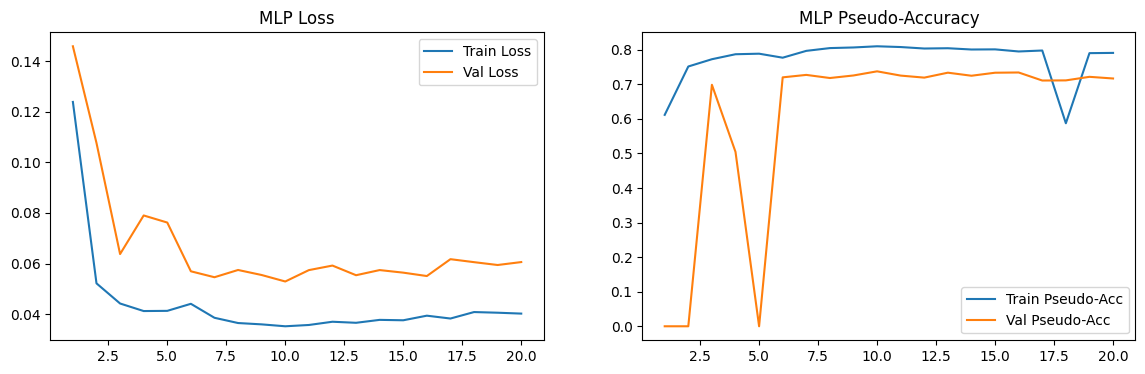

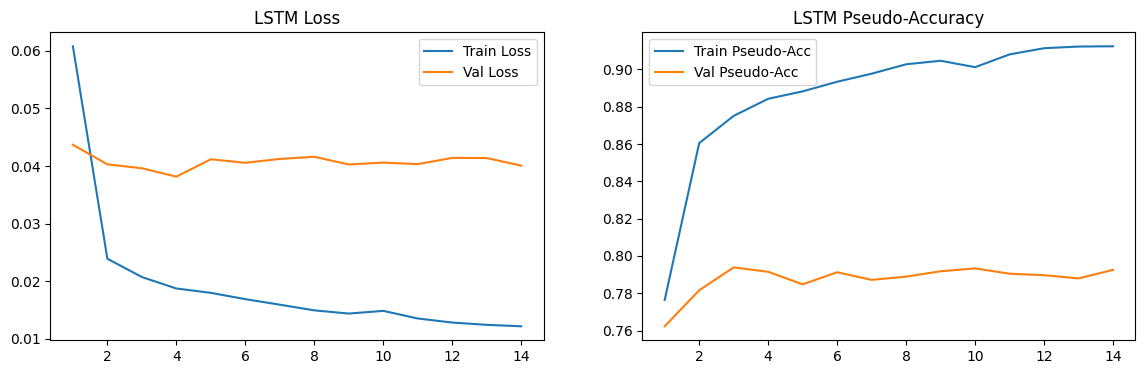

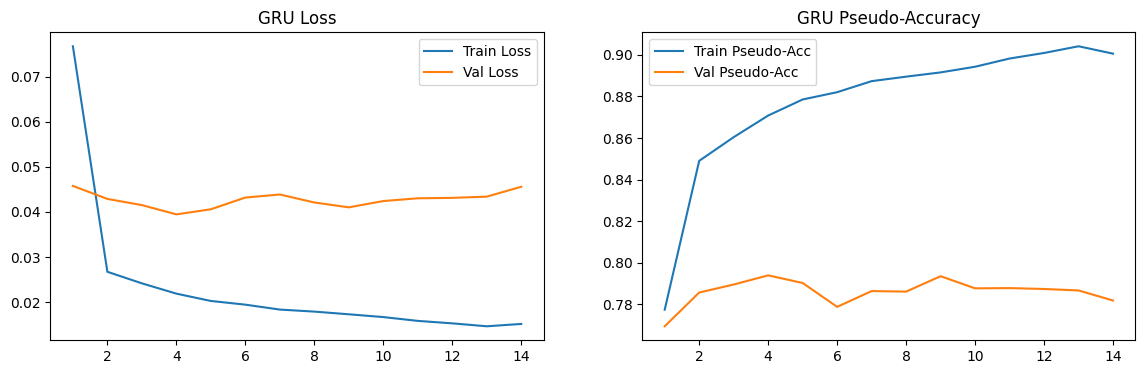

In [ ]:
def plot_history(name, history):
    epochs = range(1, len(history['train_loss'])+1)
    fig, axes = plt.subplots(1,2, figsize=(14,4))
    axes[0].plot(epochs, history['train_loss'], label='Train Loss')
    axes[0].plot(epochs, history['val_loss'], label='Val Loss')
    axes[0].set_title(f'{name} Loss'); axes[0].legend()
    axes[1].plot(epochs, history['train_acc'], label='Train Pseudo-Acc')
    axes[1].plot(epochs, history['val_acc'], label='Val Pseudo-Acc')
    axes[1].set_title(f'{name} Pseudo-Accuracy'); axes[1].legend()
    plt.show()

for name, art in model_artifacts.items():
    plot_history(name, art['history'])

## 12. Final Evaluation on Test Set

In [ ]:
def predict_model(model, loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for X, y in loader:
            X = X.to(DEVICE)
            out = model(X)
            preds.append(out.cpu().numpy())
            trues.append(y.numpy())
    return np.concatenate(trues, axis=0), np.concatenate(preds, axis=0)

train_targets_all = []
with torch.no_grad():
    for X, y in train_loader:
        train_targets_all.append(y.numpy())
train_targets_all = np.concatenate(train_targets_all, axis=0).flatten()
train_targets_all_lin = np.expm1(train_targets_all)

metrics_table = []
for name, art in model_artifacts.items():
    true_log, pred_log = predict_model(art['model'], test_loader)
    true_lin = np.expm1(true_log.flatten())
    pred_lin = np.expm1(pred_log.flatten())
    metrics = evaluate_arrays(true_lin, pred_lin, train_targets_all_lin)
    row = {'Model': name}
    row.update(metrics)
    metrics_table.append(row)

metrics_df = pd.DataFrame(metrics_table).set_index('Model')
metrics_df.sort_values('RMSE')

,MAE,RMSE,R2,MAPE,sMAPE,MASE,PseudoAccuracy
Model,,,,,,,
LSTM,0.466557,4.988021,0.014181,171624.078125,14.155202,0.442282,0.833089
GRU,0.482061,4.993527,0.012004,158175.000000,15.185722,0.456980,0.827542
MLP,0.618025,4.996702,0.010747,171285.250000,20.061796,0.585871,0.778900


## 13. Visual Comparison of Models

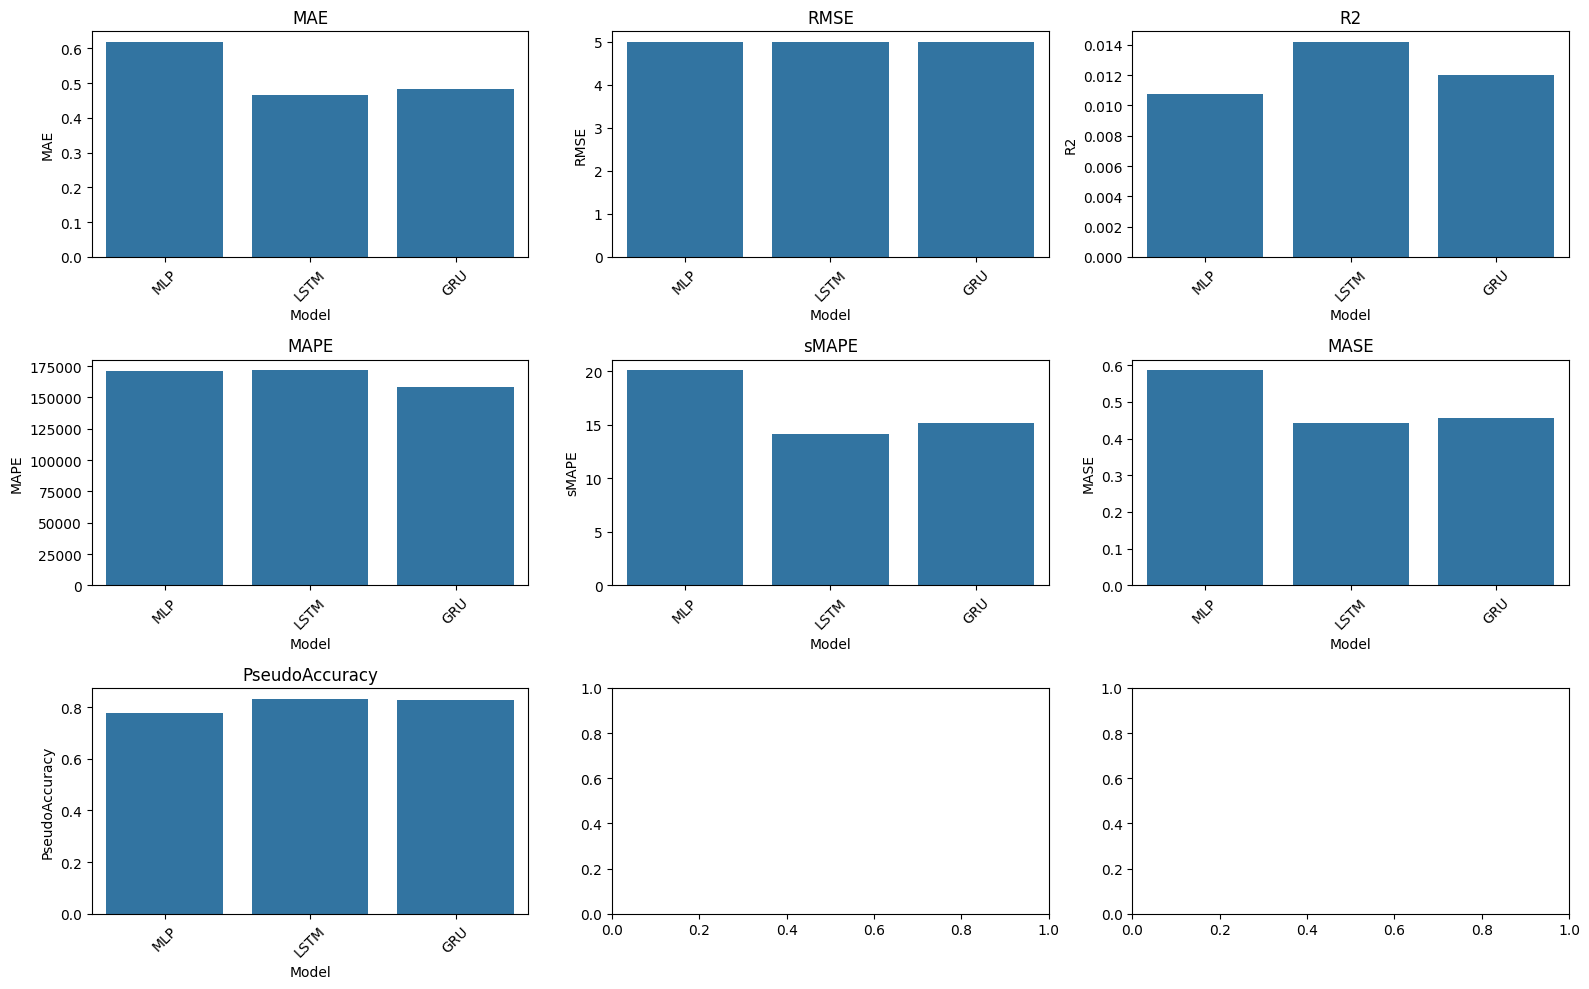

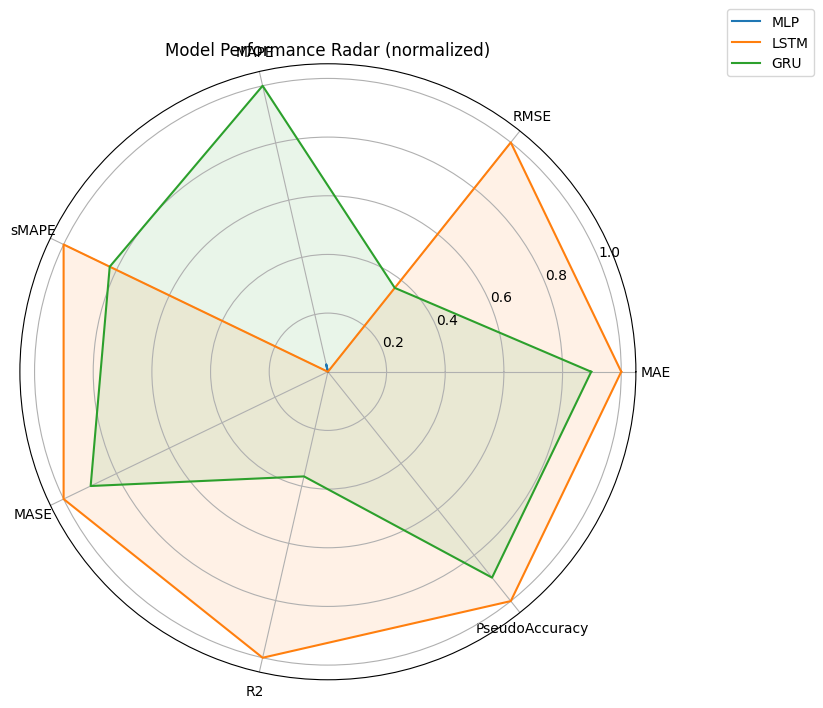

In [ ]:
metrics_plot_cols = ['MAE','RMSE','R2','MAPE','sMAPE','MASE','PseudoAccuracy']
fig, axes = plt.subplots(math.ceil(len(metrics_plot_cols)/3), 3, figsize=(16,10))
axes = axes.ravel()
for ax, metric in zip(axes, metrics_plot_cols):
    sns.barplot(x=metrics_df.index, y=metrics_df[metric], ax=ax)
    ax.set_title(metric)
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout(); plt.show()

def normalize_series(s, invert=False):
    arr = s.values.astype(float)
    mn, mx = arr.min(), arr.max()
    if mx - mn < 1e-8:
        norm = np.ones_like(arr)
    else:
        norm = (arr - mn)/(mx - mn)
    return 1 - norm if invert else norm

radar_metrics = {
    'MAE': True,
    'RMSE': True,
    'MAPE': True,
    'sMAPE': True,
    'MASE': True,
    'R2': False,
    'PseudoAccuracy': False
}
labels = list(radar_metrics.keys())
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
angles = np.concatenate([angles, [angles[0]]])

fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)
for model in metrics_df.index:
    values = []
    for m, inv in radar_metrics.items():
        values.append(normalize_series(metrics_df[m], invert=inv)[metrics_df.index.get_loc(model)])
    values = np.concatenate([values, [values[0]]])
    ax.plot(angles, values, label=model)
    ax.fill(angles, values, alpha=0.1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
plt.title('Model Performance Radar (normalized)')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()

## 14. Sample Forecast Plot (Best Model)

Best model by RMSE: LSTM


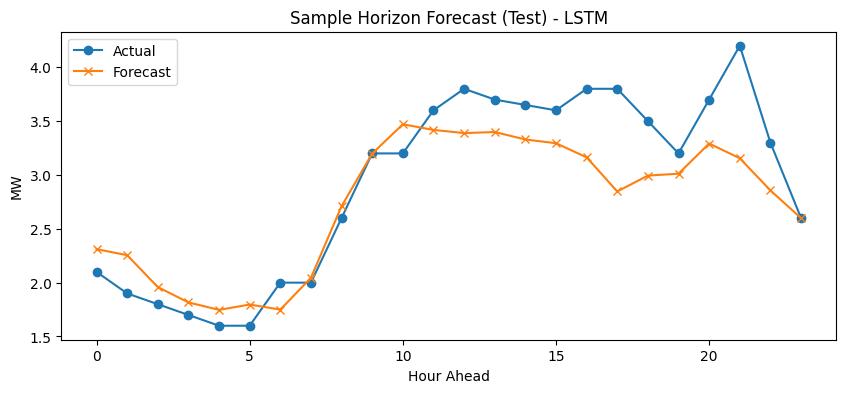

In [ ]:
best_model_name = metrics_df.sort_values('RMSE').index[0]
print('Best model by RMSE:', best_model_name)
best_model = model_artifacts[best_model_name]['model']

true_log, pred_log = predict_model(best_model, test_loader)
true_lin = np.expm1(true_log)
pred_lin = np.expm1(pred_log)

sample_idx = 0
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(true_lin[sample_idx], label='Actual', marker='o')
ax.plot(pred_lin[sample_idx], label='Forecast', marker='x')
ax.set_title(f'Sample Horizon Forecast (Test) - {best_model_name}')
ax.set_xlabel('Hour Ahead')
ax.set_ylabel('MW')
ax.legend()
plt.show()

## 15. Saving Metrics & Summary

In [ ]:
metrics_df.to_csv('models/model_metrics.csv')
with open('models/model_metrics.json','w') as f:
    json.dump(metrics_df.to_dict(orient='index'), f, indent=2)
print('Saved metrics to models/model_metrics.*')

Saved metrics to models/model_metrics.*


In [ ]:
import zipfile
import os
from IPython.display import FileLink

# Define the directory to zip and the output zip file name
directory_to_zip = 'models'
output_zip_file = 'models.zip'

# Create a ZipFile object
with zipfile.ZipFile(output_zip_file, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Walk through the directory and add all files to the zip file
    for root, _, files in os.walk(directory_to_zip):
        for file in files:
            file_path = os.path.join(root, file)
            # Add file to zip, preserving directory structure within the zip
            zipf.write(file_path, os.path.relpath(file_path, directory_to_zip))

print(f"'{directory_to_zip}' successfully zipped to '{output_zip_file}'.")

# Provide a download link
display(FileLink(output_zip_file))

'models' successfully zipped to 'models.zip'.


/content/models.zip